In [1]:
#What are we working with?
import sys
sys.version

'3.6.5 |Anaconda custom (64-bit)| (default, Apr 26 2018, 08:42:37) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

/Users/kiichitakeuchi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


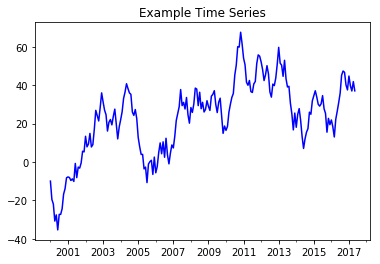

2000-01-31    -9.965375
2000-02-29   -19.518037
2000-03-31   -21.908157
2000-04-30   -30.793623
2000-05-31   -27.552547
2000-06-30   -35.394879
2000-07-31   -27.302085
2000-08-31   -27.305714
2000-09-30   -24.364985
2000-10-31   -16.770250
Freq: M, dtype: float64

In [3]:
random.seed(111)
rng = pd.date_range(start='2000', periods=209, freq='M')
ts = pd.Series(np.random.uniform(-10, 10, size=len(rng)), rng).cumsum()
ts.plot(c='b', title='Example Time Series')
plt.show()
ts.head(10)

In [4]:
TS = np.array(ts)
num_periods = 20
f_horizon = 1  #forecast horizon, one period into the future

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, 20, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1, 20, 1)
print (len(x_batches))
print (x_batches.shape)
print (x_batches[0:2])

print (y_batches[0:1])
print (y_batches.shape)

10
(10, 20, 1)
[[[ -9.9653752 ]
  [-19.51803689]
  [-21.90815653]
  [-30.79362259]
  [-27.55254715]
  [-35.39487898]
  [-27.30208532]
  [-27.30571423]
  [-24.36498514]
  [-16.77025003]
  [-13.93448038]
  [ -8.25117066]
  [ -7.77510367]
  [ -8.08885365]
  [ -9.64233349]
  [ -8.78095003]
  [-10.13288462]
  [ -0.74768517]
  [ -8.14362261]
  [ -2.65600368]]

 [[ -3.19708674]
  [ -0.4771589 ]
  [  5.63285904]
  [  5.26624626]
  [ 13.4068288 ]
  [  7.8898418 ]
  [  9.40430241]
  [ 14.91020426]
  [  7.84449213]
  [  9.05279212]
  [ 17.12745771]
  [ 26.92503601]
  [ 24.20186703]
  [ 21.38806589]
  [ 28.3030114 ]
  [ 36.02243186]
  [ 31.31428022]
  [ 27.04098546]
  [ 24.65212319]
  [ 16.13503562]]]
[[[-19.51803689]
  [-21.90815653]
  [-30.79362259]
  [-27.55254715]
  [-35.39487898]
  [-27.30208532]
  [-27.30571423]
  [-24.36498514]
  [-16.77025003]
  [-13.93448038]
  [ -8.25117066]
  [ -7.77510367]
  [ -8.08885365]
  [ -9.64233349]
  [ -8.78095003]
  [-10.13288462]
  [ -0.74768517]
  [ -8.14362

In [5]:
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testY = TS[-(num_periods):].reshape(-1, 20, 1)
    return testX,testY

X_test, Y_test = test_data(TS,f_horizon,num_periods )
print (X_test.shape)
print (X_test)

(1, 20, 1)
[[[25.32510257]
  [15.54342897]
  [22.7404514 ]
  [19.46396776]
  [21.9187604 ]
  [18.34555509]
  [13.04301011]
  [22.26239491]
  [26.42859875]
  [30.96249332]
  [35.85038825]
  [45.25144765]
  [47.42670196]
  [46.74272159]
  [40.13237963]
  [37.57615957]
  [44.79455532]
  [39.75397016]
  [37.00964331]
  [41.90993581]]]


In [6]:
tf.reset_default_graph()   #We didn't have any previous graph objects running, but this would reset the graphs

num_periods = 20      #number of periods per vector we are using to predict one period ahead
inputs = 1            #number of vectors submitted
hidden = 100          #number of neurons we will recursively work through, can be changed to improve accuracy
output = 1            #number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs])   #create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])


basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   #create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)               #choose dynamic over static

learning_rate = 0.001   #small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)        #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])          #shape of results
 
loss = tf.reduce_sum(tf.square(outputs - y))    #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #gradient descent method
training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 

init = tf.global_variables_initializer()           #initialize all the variables

In [7]:
epochs = 1000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 187971.44
100 	MSE: 8601.579
200 	MSE: 4020.0276
300 	MSE: 2038.331
400 	MSE: 1321.2852
500 	MSE: 1002.1642
600 	MSE: 860.6615
700 	MSE: 848.9608
800 	MSE: 727.6947
900 	MSE: 717.9579
[[[24.474257]
  [16.316444]
  [22.519249]
  [17.558956]
  [17.65352 ]
  [17.61293 ]
  [21.541897]
  [24.531284]
  [32.315746]
  [39.679058]
  [43.31959 ]
  [48.826546]
  [39.502556]
  [36.848133]
  [38.507366]
  [26.264055]
  [31.370525]
  [35.911816]
  [22.733192]
  [37.239304]]]


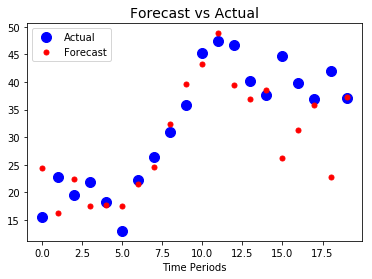

In [8]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
#plt.plot(pd.Series(np.ravel(Y_test)), "w*", markersize=10)
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()